# Statistical Analysis of Animal Longevity Across Vertebrate Classes

**Author:** Tim Wilcoxson
**Date:** February 2026
**Course:** Project 2 -- Data and Statistical Reasoning
**Dataset:** AnAge -- The Animal Ageing and Longevity Database (HAGR, 2023)
**Source:** [Human Ageing Genomic Resources](https://genomics.senescence.info/species/)

---

**Research Questions:**
1. Does maximum longevity differ significantly across five major vertebrate
   classes (Mammalia, Aves, Teleostei, Reptilia, Amphibia)?
2. What is the allometric relationship between body size and longevity?

This notebook performs a complete statistical analysis of the AnAge database
(4,645 species, 31 variables) using both a parametric baseline (ANOVA) and
a non-parametric alternative (Kruskal-Wallis H-test) to address these questions.
The analysis includes descriptive statistics, five visualizations with
interpretive commentary, formal assumption checking, hypothesis testing with
post-hoc comparisons, confidence intervals, and a sensitivity analysis.

## 1. Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
import scipy
from itertools import combinations
import os

# Reproducibility
np.random.seed(42)

# ---------------------------------------------------------------------------
# Shared style configuration (used by all figures for visual consistency)
# ---------------------------------------------------------------------------
sns.set_theme(style='whitegrid', palette='colorblind')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300       # publication-quality output
plt.rcParams['figure.figsize'] = (12, 6) # standard width = 12 inches
pd.set_option('display.max_columns', 35)
pd.set_option('display.width', 120)

# Consistent class-to-color mapping across all figures
CB_PALETTE = sns.color_palette('colorblind')
CLASS_ORDER = ['Reptilia', 'Mammalia', 'Aves', 'Amphibia', 'Teleostei']
CLASS_COLORS = {cls: CB_PALETTE[i] for i, cls in enumerate(CLASS_ORDER)}

# Standard formatting
SUPTITLE_KW = dict(fontsize=14, fontweight='bold')
FIGURES_DIR = 'figures/'
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f'Environment: Pandas {pd.__version__}, NumPy {np.__version__}, '
      f'SciPy {scipy.__version__}, Seaborn {sns.__version__}')

Environment: Pandas 3.0.1, NumPy 2.4.2, SciPy 1.17.0, Seaborn 0.13.2


## 2. Data Loading

In [2]:
# Load the AnAge dataset (4,645 species x 31 variables, CSV format)
df = pd.read_csv('data/anage_data.csv', na_values=['', 'NA'])

print(f'Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'\nColumn data types:')
print(df.dtypes)
print(f'\nFirst 5 rows:')
df.head()

Dataset shape: 4,645 rows x 31 columns

Column data types:
HAGRID                                int64
Kingdom                                 str
Phylum                                  str
Class                                   str
Order                                   str
Family                                  str
Genus                                   str
Species                                 str
Common name                             str
Female maturity (days)              float64
Male maturity (days)                float64
Gestation/Incubation (days)         float64
Weaning (days)                      float64
Litter/Clutch size                  float64
Litters/Clutches per year           float64
Inter-litter/Interbirth interval    float64
Birth weight (g)                    float64
Weaning weight (g)                  float64
Adult weight (g)                    float64
Growth rate (1/days)                float64
Maximum longevity (yrs)             float64
Source           

,HAGRID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Common name,Female maturity (days),Male maturity (days),Gestation/Incubation (days),Weaning (days),Litter/Clutch size,Litters/Clutches per year,Inter-litter/Interbirth interval,Birth weight (g),Weaning weight (g),Adult weight (g),Growth rate (1/days),Maximum longevity (yrs),Source,Specimen origin,Sample size,Data quality,IMR (per yr),MRDT (yrs),Metabolic rate (W),Body mass (g),Temperature (K),References
0,3,Animalia,Annelida,Polychaeta,Sabellida,Siboglinidae,Escarpia,laminata,Escarpia laminata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.00,1466,wild,medium,acceptable,NaN,NaN,NaN,NaN,NaN,1466
1,5,Animalia,Annelida,Polychaeta,Sabellida,Siboglinidae,Lamellibrachia,luymesi,Lamellibrachia luymesi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.00,652,wild,small,acceptable,NaN,NaN,NaN,NaN,NaN,652
2,6,Animalia,Annelida,Polychaeta,Sabellida,Siboglinidae,Seepiophila,jonesi,Seepiophila jonesi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.00,1467,wild,small,acceptable,NaN,NaN,NaN,NaN,NaN,1467
3,8,Animalia,Arthropoda,Arachnida,Araneae,Theridiidae,Latrodectus,hasselti,Australian redback spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,medium,low,NaN,NaN,NaN,NaN,NaN,1455
4,9,Animalia,Arthropoda,Branchiopoda,Diplostraca,Daphniidae,Daphnia,pulicaria,Daphnia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,NaN,unknown,medium,acceptable,NaN,NaN,NaN,NaN,NaN,"1294,1295,1296"


## 3. Data Cleaning and Preparation

In [3]:
# Assess missing data across all columns
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_report = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).query('missing_count > 0').sort_values('missing_pct', ascending=False)

print(f'Columns with missing values ({len(missing_report)} of {len(df.columns)}):')
missing_report

Columns with missing values (19 of 31):


,missing_count,missing_pct
IMR (per yr),4602,99.1
MRDT (yrs),4602,99.1
Weaning weight (g),4261,91.7
Temperature (K),4151,89.4
Growth rate (1/days),4086,88.0
Metabolic rate (W),4018,86.5
Body mass (g),4018,86.5
Weaning (days),3877,83.5
Inter-litter/Interbirth interval,3880,83.5
Birth weight (g),3415,73.5


In [4]:
# Rename columns to snake_case for consistent programmatic access
rename_map = {
    'Common name': 'common_name',
    'Maximum longevity (yrs)': 'max_longevity_yrs',
    'Adult weight (g)': 'adult_weight_g',
    'Female maturity (days)': 'female_maturity_days',
    'Male maturity (days)': 'male_maturity_days',
    'Gestation/Incubation (days)': 'gestation_days',
    'Litter/Clutch size': 'litter_size',
    'Litters/Clutches per year': 'litters_per_year',
    'Birth weight (g)': 'birth_weight_g',
    'Weaning weight (g)': 'weaning_weight_g',
    'Weaning (days)': 'weaning_days',
    'Growth rate (1/days)': 'growth_rate',
    'Inter-litter/Interbirth interval': 'interbirth_interval',
    'Metabolic rate (W)': 'metabolic_rate_w',
    'Body mass (g)': 'body_mass_g',
    'Temperature (K)': 'temperature_k',
    'Sample size': 'sample_size',
    'Specimen origin': 'specimen_origin',
    'Data quality': 'data_quality',
    'IMR (per yr)': 'imr',
    'MRDT (yrs)': 'mrdt',
    'Source': 'source',
    'References': 'references'
}
df = df.rename(columns=rename_map)

# Log10 transforms for variables spanning many orders of magnitude.
# Body weight ranges from 0.5 g (insects) to 136,000,000 g (blue whale);
# longevity ranges from 0.01 to 15,000 years. Log10 is standard in
# allometric studies because 1 unit = a 10-fold change.
df['log10_longevity'] = np.log10(df['max_longevity_yrs'])
df['log10_adult_weight'] = np.log10(df['adult_weight_g'])

# Use shared CLASS_ORDER from setup cell
VERTEBRATE_CLASSES = CLASS_ORDER

print('Species per taxonomic class (top 10):')
print(df['Class'].value_counts().head(10))
vert_count = df[df['Class'].isin(VERTEBRATE_CLASSES)].shape[0]
print(f'\nFive target classes contain {vert_count:,} of {len(df):,} total species')

# Save cleaned dataset for reproducibility
df.to_csv('data/anage_cleaned.csv', index=False)
print(f'Cleaned dataset saved: {len(df):,} rows x {len(df.columns)} columns')

Species per taxonomic class (top 10):
Class
Aves                  1513
Mammalia              1349
Teleostei              806
Reptilia               547
Amphibia               181
Chondrichthyes         117
Bivalvia                43
Cephalaspidomorphi      16
Chondrostei             14
Insecta                 13
Name: count, dtype: int64

Five target classes contain 4,396 of 4,645 total species
Cleaned dataset saved: 4,645 rows x 33 columns


## 4. Descriptive Statistics

In [5]:
# Summary statistics for key numeric variables
numeric_cols = ['max_longevity_yrs', 'adult_weight_g', 'female_maturity_days',
                'gestation_days', 'litter_size', 'birth_weight_g']
df[numeric_cols].describe().round(2)

,max_longevity_yrs,adult_weight_g,female_maturity_days,gestation_days,litter_size,birth_weight_g
count,4141.00,3.663000e+03,2485.00,1835.00,2.093000e+03,1230.00
mean,25.52,1.763312e+05,1029.44,88.74,1.449034e+05,11450.08
std,251.24,3.294818e+06,1656.83,196.46,6.557596e+06,107196.99
min,0.01,5.000000e-01,3.00,1.00,1.000000e+00,0.00
25%,8.80,4.750000e+01,365.00,21.00,1.000000e+00,3.24
50%,15.00,4.565000e+02,578.00,36.00,3.000000e+00,24.65
75%,24.00,3.500000e+03,1186.00,126.00,5.000000e+00,250.00
max,15000.00,1.360000e+08,56940.00,7397.00,3.000000e+08,2000000.00


In [6]:
# Skewness and kurtosis quantify departures from normality.
# Skewness > 2 = severe right-skew; excess kurtosis > 7 = very heavy tails.
skew_kurt = df[numeric_cols].agg(['skew', 'kurt']).round(2)
skew_kurt.index = ['Skewness', 'Excess Kurtosis']
print('Distributional shape metrics:')
print(skew_kurt)
print(f'\nLongevity: skewness = {df["max_longevity_yrs"].skew():.2f}, '
      f'kurtosis = {df["max_longevity_yrs"].kurtosis():.2f}')
print('Interpretation: Severe positive skew and leptokurtosis confirm')
print('that parametric methods assuming normality are inappropriate.')

Distributional shape metrics:
                 max_longevity_yrs  adult_weight_g  female_maturity_days  gestation_days  litter_size  birth_weight_g
Skewness                     53.42           30.83                 16.90           28.32        45.75           13.41
Excess Kurtosis            3091.56         1088.17                527.39         1044.98      2092.80          200.76

Longevity: skewness = 53.42, kurtosis = 3091.56
Interpretation: Severe positive skew and leptokurtosis confirm
that parametric methods assuming normality are inappropriate.


In [7]:
# Categorical variable distributions
print('Data quality ratings:')
print(df['data_quality'].value_counts())
print('\nSpecimen origin:')
print(df['specimen_origin'].value_counts())

# Longevity statistics grouped by vertebrate class
print('\nLongevity by vertebrate class:')
class_stats = (
    df[df['Class'].isin(VERTEBRATE_CLASSES)]
    .groupby('Class')['max_longevity_yrs']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .round(2)
    .sort_values('median', ascending=False)
)
class_stats

Data quality ratings:
data_quality
acceptable      3926
low              504
high             108
questionable     107
Name: count, dtype: int64

Specimen origin:
specimen_origin
wild         2100
captivity    1920
unknown       625
Name: count, dtype: int64

Longevity by vertebrate class:


,count,mean,median,std,min,max
Class,,,,,,
Reptilia,526,22.02,17.80,17.81,1.30,177.0
Mammalia,1029,19.76,17.00,15.60,2.10,211.0
Aves,1394,17.78,14.60,11.36,0.60,83.0
Amphibia,162,14.88,11.95,10.71,2.00,102.0
Teleostei,798,16.97,10.00,21.56,0.16,205.0


**Interpretation of Descriptive Statistics**

- **Right-skewed distribution:** The overall mean longevity (25.5 years) is
  nearly double the median (15.0 years), indicating severe right-skew driven
  by a small number of exceptionally long-lived species. This motivates log
  transformations and non-parametric tests in subsequent sections.
- **Class-level differences:** Reptilia has the highest median longevity
  (17.8 years), followed by Mammalia (17.0 years). Teleostei (bony fish) has
  the lowest median (10.0 years) but the widest spread (SD = 21.6), reflecting
  enormous diversity from short-lived tropical fish to sturgeon and rockfish
  exceeding 200 years.
- **Missing data patterns:** Longevity is 89% complete and adult weight is
  79% complete, making them the most reliable analysis variables. Metabolic
  rate is only 14% complete, preventing metabolic scaling analysis.
- **Data provenance:** 84% of records have "acceptable" quality ratings.
  Approximately 45% come from wild specimens and 41% from captivity, which
  is important context for interpreting maximum longevity values.
- **Data quality note:** The litter/clutch size column shows a maximum of
  300,000,000, which is almost certainly a data entry error (no vertebrate
  produces clutches of this magnitude). While this does not affect our
  primary analysis variables (longevity and weight), it illustrates the
  importance of examining extreme values before analysis -- a key principle
  of the IDA framework (Lusa et al., 2024).

## 5. Visualizations

Four visualizations are produced following principles for effective
statistical graphics (Midway, 2020): histograms, box plots, scatter plots,
bar charts, and Q-Q plots. Each figure uses the shared colorblind-safe
palette and class-color mapping defined in the setup cell for visual
consistency.

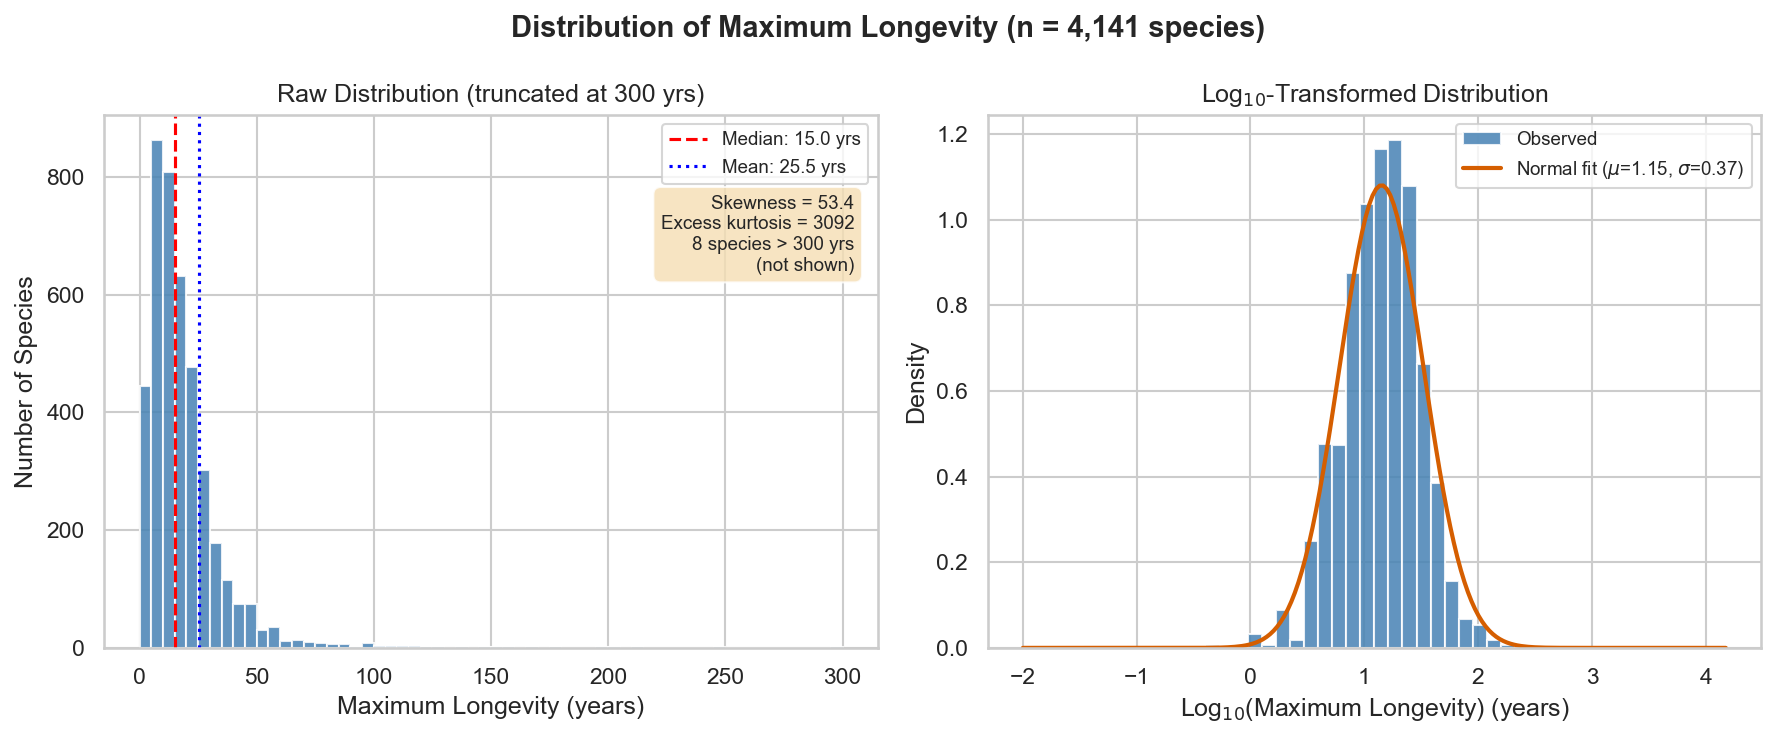

Figure 1 saved.


In [8]:
# Figure 1: Distribution of Maximum Longevity (raw vs. log-transformed)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
BASE_COLOR = 'steelblue'

longevity = df['max_longevity_yrs'].dropna()
log_long = df['log10_longevity'].dropna()

# Left panel: raw values truncated at 300 yrs for readability
ax = axes[0]
clipped = longevity[longevity <= 300]
ax.hist(clipped, bins=60, color=BASE_COLOR, edgecolor='white', alpha=0.85)
ax.set_xlabel('Maximum Longevity (years)')
ax.set_ylabel('Number of Species')
ax.set_title('Raw Distribution (truncated at 300 yrs)')
ax.axvline(longevity.median(), color='red', linestyle='--', linewidth=1.5,
           label=f'Median: {longevity.median():.1f} yrs')
ax.axvline(longevity.mean(), color='blue', linestyle=':', linewidth=1.5,
           label=f'Mean: {longevity.mean():.1f} yrs')
ax.legend(fontsize=9)
# Annotate skewness and count of excluded outliers
n_excluded = (longevity > 300).sum()
ax.text(0.97, 0.85, f'Skewness = {longevity.skew():.1f}\n'
        f'Excess kurtosis = {longevity.kurtosis():.0f}\n'
        f'{n_excluded} species > 300 yrs\n'
        f'(not shown)',
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.8))

# Right panel: log10-transformed with normal density overlay
ax = axes[1]
ax.hist(log_long, bins=50, color=BASE_COLOR, edgecolor='white', alpha=0.85,
        density=True, label='Observed')
# Fitted normal overlay
mu, sigma = log_long.mean(), log_long.std()
x_norm = np.linspace(log_long.min(), log_long.max(), 200)
ax.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), 'r-', linewidth=2,
        label=f'Normal fit ($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')
ax.set_xlabel('Log$_{10}$(Maximum Longevity) (years)')
ax.set_ylabel('Density')
ax.set_title('Log$_{10}$-Transformed Distribution')
ax.legend(fontsize=9)

fig.suptitle(f'Distribution of Maximum Longevity (n = {len(longevity):,} species)',
             **SUPTITLE_KW)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}fig1_longevity_distribution.png', bbox_inches='tight')
plt.show()
print('Figure 1 saved.')

**Interpretation:** Figure 1 demonstrates why log transformation is essential
for this analysis. The raw distribution (left) shows extreme positive skewness:
most species cluster below 50 years while a long tail extends to hundreds of
years. The mean (25.5 years) substantially overestimates the typical species'
lifespan compared to the median (15.0 years). The log10 transformation (right)
produces an approximately symmetric distribution, confirming that longevity
follows a roughly lognormal pattern common in biological size and time variables.
Subsequent visualizations and statistical comparisons use the log-transformed
scale to prevent outlier-driven distortions.

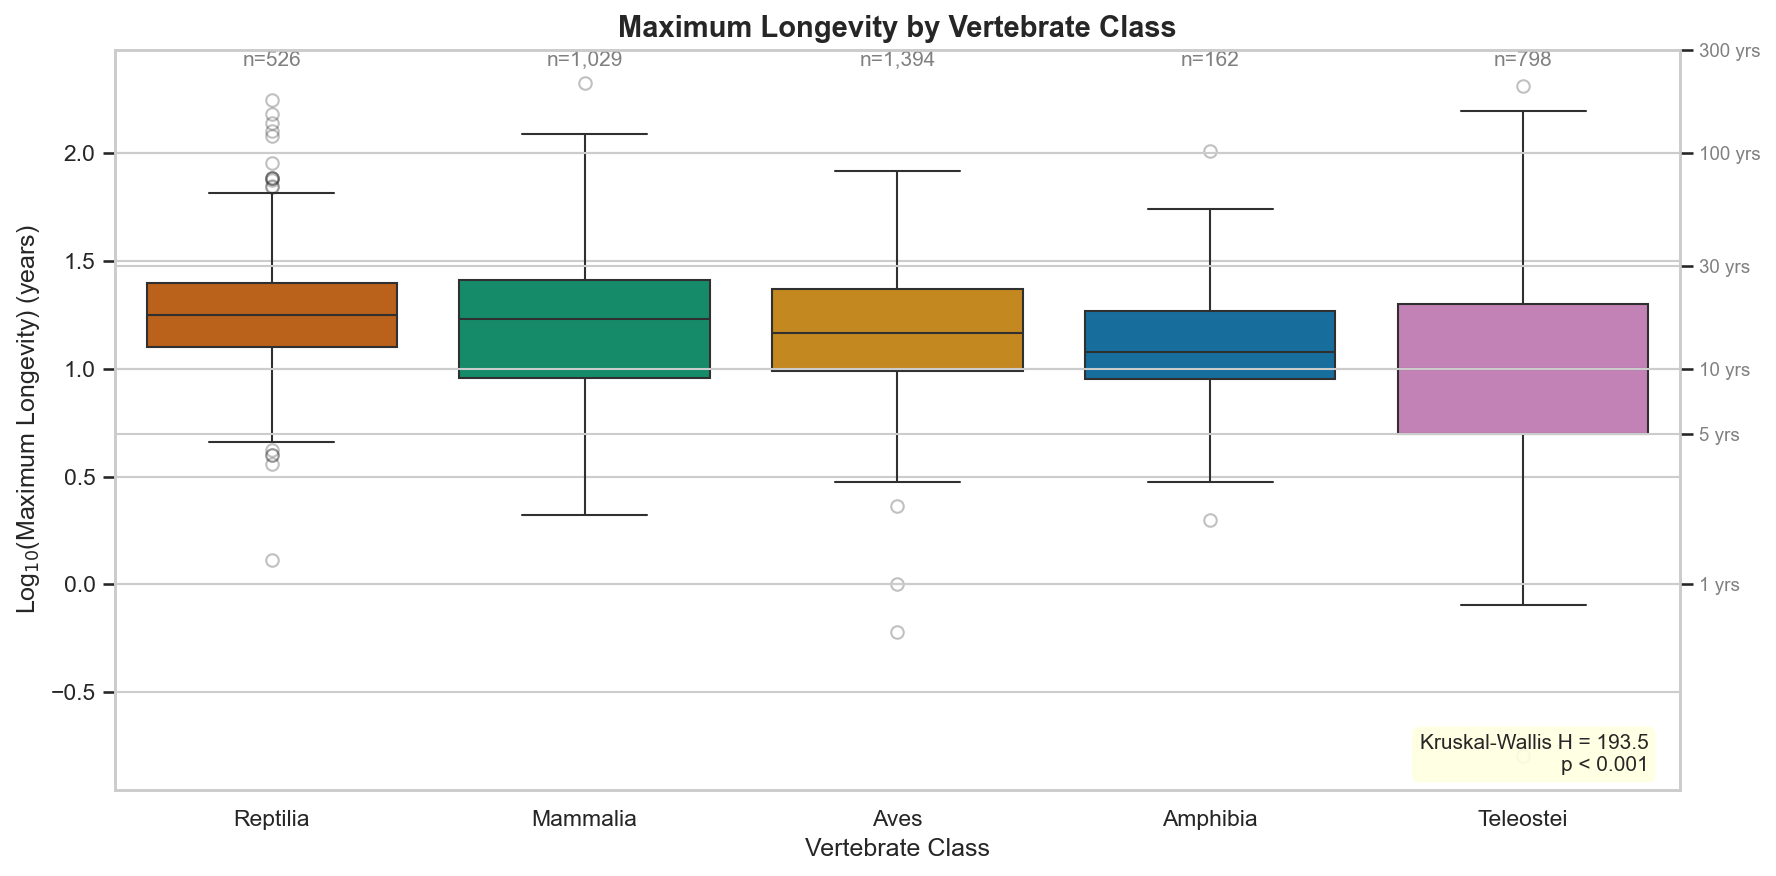

Figure 2 saved.


In [9]:
# Figure 2: Longevity by Vertebrate Class (boxplot)
top5_df = df[df['Class'].isin(VERTEBRATE_CLASSES)].copy()
order = (top5_df.groupby('Class')['max_longevity_yrs']
         .median().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(12, 6))
palette = [CLASS_COLORS[c] for c in order]
sns.boxplot(data=top5_df, x='Class', y='log10_longevity', hue='Class',
            order=order, palette=palette, legend=False,
            flierprops={'alpha': 0.3}, ax=ax)
ax.set_xlabel('Vertebrate Class')
ax.set_ylabel('Log$_{10}$(Maximum Longevity) (years)')
ax.set_title('Maximum Longevity by Vertebrate Class', **SUPTITLE_KW)

# Sample size annotations above each box
for i, cls in enumerate(order):
    n = top5_df[top5_df['Class'] == cls]['log10_longevity'].notna().sum()
    ax.text(i, ax.get_ylim()[1] * 0.97, f'n={n:,}', ha='center',
            fontsize=10, color='gray')

# Back-transformed secondary y-axis (actual years)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
tick_years = [1, 5, 10, 30, 100, 300]
ax2.set_yticks([np.log10(y) for y in tick_years])
ax2.set_yticklabels([f'{y} yrs' for y in tick_years], fontsize=9, color='gray')
ax2.set_ylabel('')

# Compute KW inline so the annotation is dynamic (not hardcoded)
_kw_groups = [grp['max_longevity_yrs'].values
              for _, grp in top5_df.dropna(subset=['max_longevity_yrs']).groupby('Class')]
_h_inline, _p_inline = stats.kruskal(*_kw_groups)
ax.text(0.98, 0.02, f'Kruskal-Wallis H = {_h_inline:.1f}\np < 0.001',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}fig2_longevity_by_class.png', bbox_inches='tight')
plt.show()
print('Figure 2 saved.')

**Interpretation:** Figure 2 reveals both the between-class differences and
the substantial within-class variation that characterize vertebrate longevity.
Reptilia shows the highest median log-longevity, followed closely by Mammalia,
while Teleostei has the lowest median but the widest interquartile range.
The extensive overlap between class distributions foreshadows the small effect
size found in Section 6: class membership provides some information about
expected longevity but does not sharply separate the groups. The numerous
outliers visible above each box, particularly for Aves and Mammalia, further
illustrate the heavy-tailed nature of the data.

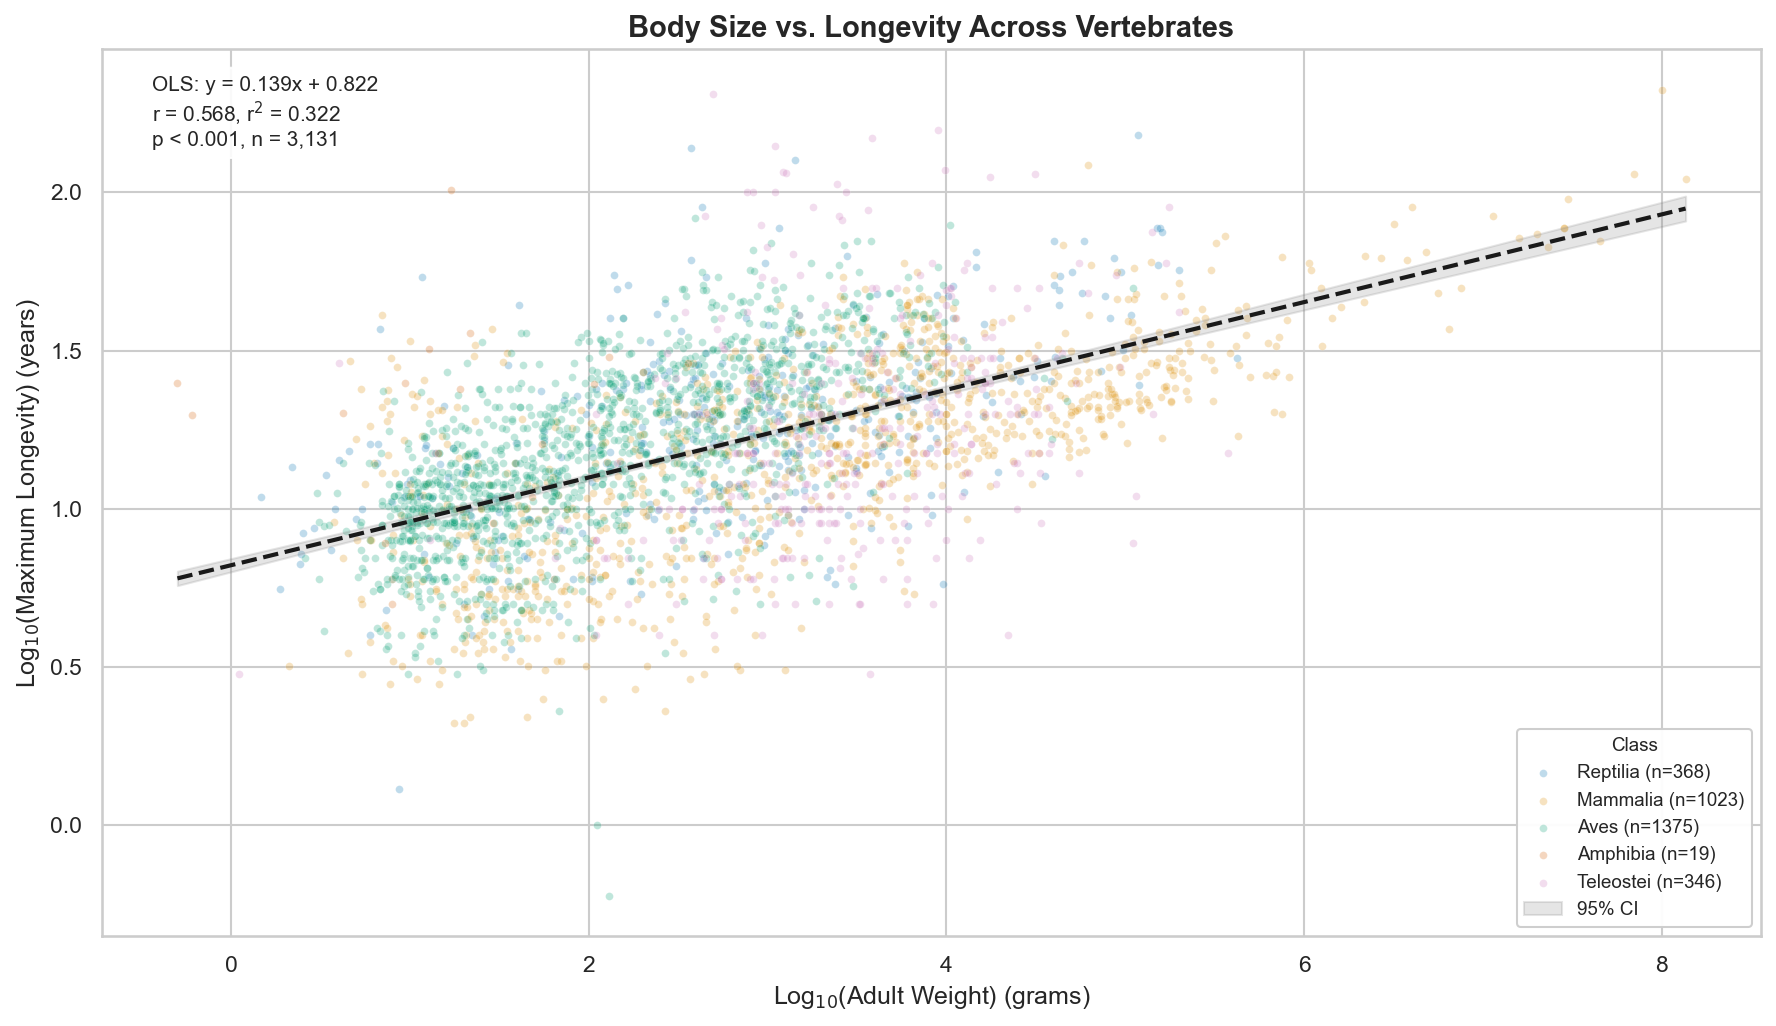

Figure 3 saved. Pearson r = 0.5678, p = 8.43e-267, n = 3131


In [10]:
# Figure 3: Body Weight vs. Longevity (allometric scaling)
subset = df.dropna(subset=['log10_adult_weight', 'log10_longevity'])
subset = subset[subset['Class'].isin(VERTEBRATE_CLASSES)]

fig, ax = plt.subplots(figsize=(12, 7))

# Plot each class with consistent colors, reduced overplotting
for cls in CLASS_ORDER:
    mask = subset['Class'] == cls
    n_cls = mask.sum()
    ax.scatter(subset.loc[mask, 'log10_adult_weight'],
               subset.loc[mask, 'log10_longevity'],
               c=[CLASS_COLORS[cls]], label=f'{cls} (n={n_cls})',
               alpha=0.25, s=14, edgecolors='white', linewidths=0.3)

# OLS regression with 95% confidence band
x = subset['log10_adult_weight'].values
y = subset['log10_longevity'].values
slope, intercept, r_val, p_val, se = stats.linregress(x, y)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = intercept + slope * x_line

# Confidence band for the mean response
n = len(x)
x_mean = x.mean()
se_line = np.sqrt((1/n) + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
residuals = y - (intercept + slope * x)
s_resid = np.sqrt(np.sum(residuals**2) / (n - 2))
ci95 = 1.96 * s_resid * se_line

ax.plot(x_line, y_line, 'k--', linewidth=2)
ax.fill_between(x_line, y_line - ci95, y_line + ci95,
                color='gray', alpha=0.2, label='95% CI')

# Regression annotation as text box (not crammed in legend)
r_sq = r_val**2
ax.text(0.03, 0.97,
        f'OLS: y = {slope:.3f}x + {intercept:.3f}\n'
        f'r = {r_val:.3f}, r$^2$ = {r_sq:.3f}\n'
        f'p < 0.001, n = {n:,}',
        transform=ax.transAxes, ha='left', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

ax.set_xlabel('Log$_{10}$(Adult Weight) (grams)')
ax.set_ylabel('Log$_{10}$(Maximum Longevity) (years)')
ax.set_title('Body Size vs. Longevity Across Vertebrates', **SUPTITLE_KW)
ax.legend(title='Class', fontsize=9, title_fontsize=9, loc='lower right',
          framealpha=0.95)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}fig3_weight_vs_longevity.png', bbox_inches='tight')
plt.show()
print(f'Figure 3 saved. Pearson r = {r_val:.4f}, p = {p_val:.2e}, n = {n}')

**Interpretation:** Figure 3 quantifies the classic allometric relationship
between body size and longevity. The positive slope (r = 0.57) confirms that
larger vertebrates tend to live longer, consistent with established allometric
scaling theory (Speakman, 2005). However, the moderate correlation
(r-squared ~ 0.32) indicates that body size explains only about one-third of
the variation in longevity. The colored points reveal that different classes
occupy distinct regions of the body-size/longevity space: mammals and birds
cluster at higher weights and longer lifespans, while teleost fish span the
widest range on both axes. The within-class scatter around the regression line
suggests that class-specific metabolic and ecological factors contribute
independently to longevity beyond the body-size effect.

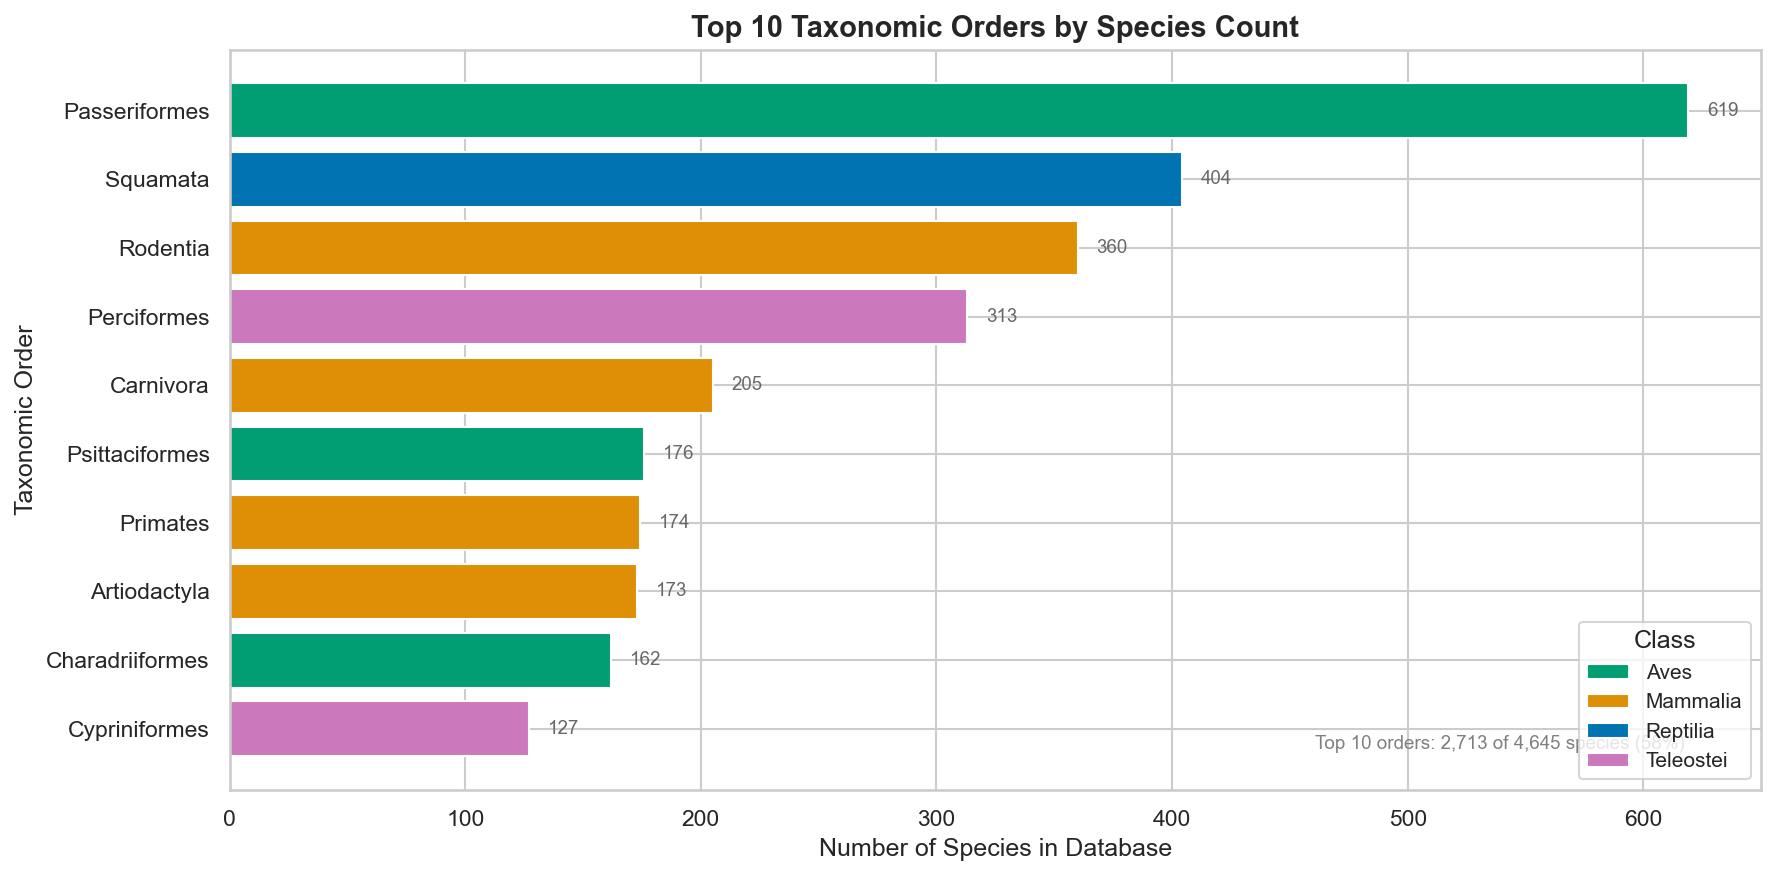

Figure 4 saved.


In [11]:
# Figure 4: Top 10 Taxonomic Orders by Species Count
order_totals = df.groupby('Order').size().nlargest(10).sort_values(ascending=True)
order_class = df[df['Order'].isin(order_totals.index)].groupby('Order')['Class'].agg(
    lambda x: x.value_counts().index[0])

bar_colors = [CLASS_COLORS.get(order_class[o], 'gray') for o in order_totals.index]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(order_totals)), order_totals.values,
               color=bar_colors, edgecolor='white')
ax.set_yticks(range(len(order_totals)))
ax.set_yticklabels(order_totals.index)
ax.set_xlabel('Number of Species in Database')
ax.set_ylabel('Taxonomic Order')
ax.set_title('Top 10 Taxonomic Orders by Species Count', **SUPTITLE_KW)

# Bar-end count labels
for i, (count, bar) in enumerate(zip(order_totals.values, bars)):
    ax.text(count + 8, i, str(count), va='center', fontsize=9, color='dimgray')

# Total species context (position inward to avoid truncation)
top10_total = order_totals.sum()
ax.text(0.95, 0.05,
        f'Top 10 orders: {top10_total:,} of {len(df):,} species ({top10_total/len(df)*100:.0f}%)',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
        color='gray')

# Class legend
unique_classes = sorted(order_class.unique())
legend_elements = [Patch(facecolor=CLASS_COLORS[c], label=c) for c in unique_classes]
ax.legend(handles=legend_elements, title='Class', loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}fig4_top_orders.png', bbox_inches='tight',
            pad_inches=0.15)
plt.show()
print('Figure 4 saved.')

**Interpretation:** Figure 4 exposes a critical source of sampling bias in the
AnAge database. The ten most-represented taxonomic orders account for a
disproportionate share of the data, with Passeriformes (songbirds, n = 619)
alone comprising 13% of all records. This overrepresentation means that the
hypothesis test results are more statistically precise for Aves and Mammalia
than for Amphibia (n = 162), where the smaller sample size reduces statistical
power. The class-level coloring reveals that the bias is concentrated in birds
and mammals, reflecting historical research priorities. Any interpretation of
cross-class differences should account for this uneven sampling.

## 6. Hypothesis Test

**Research Question:** Does maximum longevity differ significantly across
vertebrate classes (Aves, Mammalia, Teleostei, Reptilia, Amphibia)?

**H₀ (Null Hypothesis):** The distribution of maximum longevity is the same
across all five vertebrate classes.

**H₁ (Alternative Hypothesis):** At least one class has a significantly
different central tendency in longevity (as measured by mean ranks).

**Analytical Design:** Following the Initial Data Analysis (IDA) framework
for reproducible analysis (Lusa et al., 2024), we first screen the data
for distributional properties and assumption violations before selecting
a test. We then compare two approaches:

1. **Baseline (Parametric):** One-way ANOVA, which compares group means
   and assumes normality and equal variances.
2. **Selected (Non-Parametric):** Kruskal-Wallis H-test (Kruskal & Wallis,
   1952), which compares rank distributions and does not require these
   assumptions.

By running both, we can demonstrate how assumption violations affect the
results and justify the final method selection.

**Significance level:** α = 0.05

### 6.1 Assumption Checking

Before selecting a test, we verify the assumptions required by the
parametric alternative (ANOVA). As Lusa et al. (2024) emphasize,
screening data properties before analysis is essential for reproducible
and reliable results. We use the Shapiro-Wilk test (Shapiro & Wilk, 1965)
for normality and Levene's test (Levene, 1960) for homogeneity of variances.

Levene's test for equal variances (Levene, 1960):
  W = 12.4503, p = 4.59e-10
  -> Variances are UNEQUAL (confirms one-way ANOVA would be inappropriate)



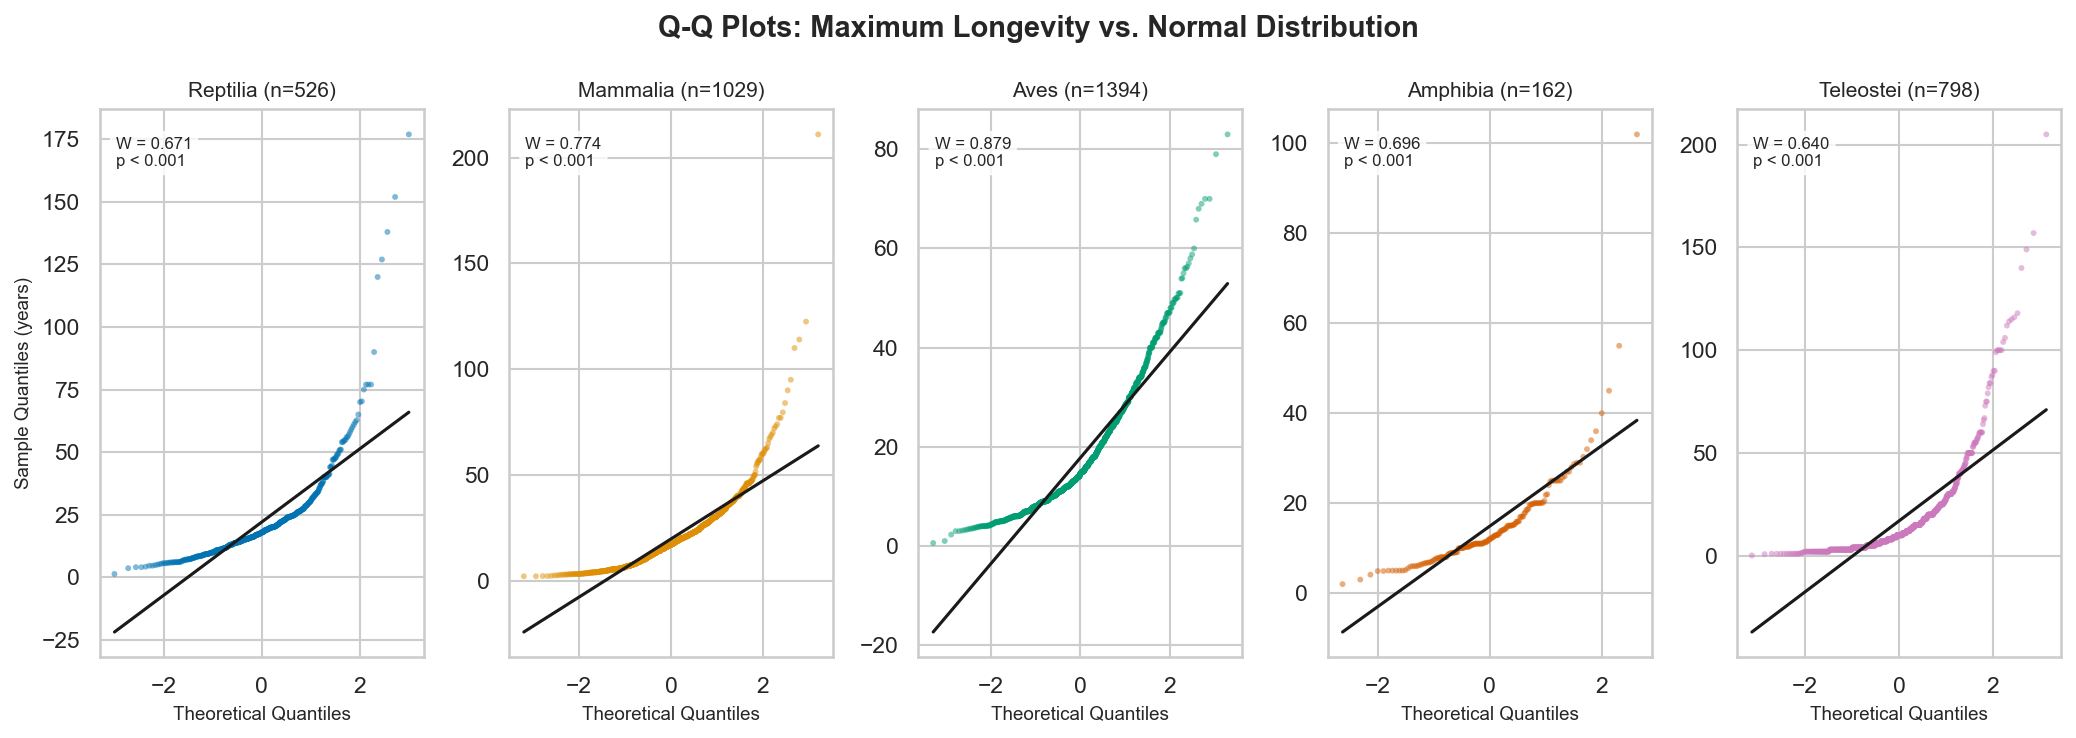

All 5 classes show heavy right-tail departure from normality,
confirmed by Shapiro-Wilk tests (all p < 0.001).


In [12]:
# Prepare data: filter to vertebrate classes with non-null longevity
test_df = df[df['Class'].isin(VERTEBRATE_CLASSES)].dropna(subset=['max_longevity_yrs'])
groups = [grp['max_longevity_yrs'].values for _, grp in test_df.groupby('Class')]

# Levene's test (Levene, 1960): checks the equal-variance assumption
levene_stat, levene_p = stats.levene(*groups)
print(f"Levene's test for equal variances (Levene, 1960):")
print(f"  W = {levene_stat:.4f}, p = {levene_p:.2e}")
print(f"  -> Variances are {'UNEQUAL' if levene_p < 0.05 else 'equal'} "
      f"(confirms one-way ANOVA would be inappropriate)\n")

# Q-Q plots for ALL 5 vertebrate classes with Shapiro-Wilk annotations
fig, axes = plt.subplots(1, 5, figsize=(14, 5))
sw_results = {}  # store for later use
for idx, (ax, cls) in enumerate(zip(axes, CLASS_ORDER)):
    class_data = test_df[test_df['Class'] == cls]['max_longevity_yrs'].dropna()
    color = CLASS_COLORS[cls]

    # Q-Q plot
    (osm, osr), (slope_qq, intercept_qq, _) = stats.probplot(class_data, dist='norm')
    ax.scatter(osm, osr, s=8, alpha=0.5, color=color, edgecolors='none')
    ax.plot(osm, intercept_qq + slope_qq * np.array(osm), 'k-', linewidth=1.5)

    ax.set_title(f'{cls} (n={len(class_data)})', fontsize=10)
    ax.set_xlabel('Theoretical Quantiles', fontsize=9)
    if idx == 0:
        ax.set_ylabel('Sample Quantiles (years)', fontsize=9)
    else:
        ax.set_ylabel('')

    # Shapiro-Wilk annotation (dynamic p-value formatting)
    w_stat, sw_p = stats.shapiro(class_data)
    sw_results[cls] = (w_stat, sw_p)
    p_str = f'p = {sw_p:.1e}' if sw_p >= 0.001 else 'p < 0.001'
    ax.text(0.05, 0.95, f'W = {w_stat:.3f}\n{p_str}',
            transform=ax.transAxes, ha='left', va='top', fontsize=8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

fig.suptitle('Q-Q Plots: Maximum Longevity vs. Normal Distribution',
             **SUPTITLE_KW)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}fig5_qq_plots.png', bbox_inches='tight')
plt.show()
print('All 5 classes show heavy right-tail departure from normality,')
print('confirmed by Shapiro-Wilk tests (all p < 0.001).')

In [13]:
# Shapiro-Wilk normality tests (Shapiro & Wilk, 1965) — formal quantitative
# confirmation of the Q-Q visual evidence above.
print('Shapiro-Wilk normality tests by class:')
print(f'{"Class":<12} {"W-statistic":>12} {"p-value":>12} {"Normal?":>10}')
print('-' * 50)
for cls in VERTEBRATE_CLASSES:
    w_stat, sw_p = sw_results[cls]
    normal = 'Yes' if sw_p >= 0.05 else 'No'
    print(f'{cls:<12} {w_stat:>12.4f} {sw_p:>12.2e} {normal:>10}')
print(f'\nAll five classes reject normality (p < 0.001), providing formal')
print(f'quantitative confirmation of the visual Q-Q plot evidence above.')

Shapiro-Wilk normality tests by class:
Class         W-statistic      p-value    Normal?
--------------------------------------------------
Reptilia           0.6712     1.20e-30         No
Mammalia           0.7736     2.02e-35         No
Aves               0.8790     1.33e-31         No
Amphibia           0.6959     6.80e-17         No
Teleostei          0.6396     7.35e-38         No

All five classes reject normality (p < 0.001), providing formal
quantitative confirmation of the visual Q-Q plot evidence above.


### 6.2 Baseline Approach: One-Way ANOVA (Parametric)

As a baseline, we apply the standard one-way ANOVA. This is the default
parametric test for comparing means across groups, but it assumes
normality within each group and equal variances across groups. Both
assumptions are violated here (confirmed above), so these results serve
as a comparison point rather than the primary analysis.

In [14]:
# Baseline: One-Way ANOVA (parametric)
# Compares group means; assumes normality + homoscedasticity.
# Both assumptions are violated, but we run it for comparison.
n_total = sum(len(g) for g in groups)
k = len(groups)

f_stat, anova_p = stats.f_oneway(*groups)

# Effect size: eta-squared = (F * df_between) / (F * df_between + df_within)
eta_sq = (f_stat * (k - 1)) / (f_stat * (k - 1) + (n_total - k))

print('BASELINE: One-Way ANOVA')
print(f'  F-statistic    = {f_stat:.4f}')
print(f'  p-value        = {anova_p:.2e}')
print(f'  Effect size    = {eta_sq:.4f} (eta-squared)')
print(f'  Groups (k)     = {k}')
print(f'  Total n        = {n_total:,}')
print(f'\nConclusion: {"REJECT" if anova_p < 0.05 else "FAIL TO REJECT"} H0.')
print(f'\nCaveat: Normality and equal-variance assumptions are violated.')
print(f'Results may be unreliable. See non-parametric alternative below.')

BASELINE: One-Way ANOVA
  F-statistic    = 12.6702
  p-value        = 3.03e-10
  Effect size    = 0.0128 (eta-squared)
  Groups (k)     = 5
  Total n        = 3,909

Conclusion: REJECT H0.

Caveat: Normality and equal-variance assumptions are violated.
Results may be unreliable. See non-parametric alternative below.


### 6.3 Selected Approach: Kruskal-Wallis H-Test (Non-Parametric)

Given the assumption violations documented above (non-normality and
unequal variances) combined with highly unbalanced group sizes, the
Kruskal-Wallis test is the appropriate alternative. It compares rank
distributions rather than means, making it robust to these violations
(Kruskal & Wallis, 1952).

In [15]:
# Kruskal-Wallis H-test (non-parametric one-way ANOVA on ranks)
h_stat, kw_p = stats.kruskal(*groups)
n_total = sum(len(g) for g in groups)

# Effect size: epsilon-squared = H / (n - 1)
# Measures proportion of variance in ranks explained by group membership.
# Benchmarks: ~0.01 = small, ~0.06 = medium, ~0.14 = large
epsilon_sq = h_stat / (n_total - 1)

print('Kruskal-Wallis H-test Results:')
print(f'  H-statistic    = {h_stat:.4f}')
print(f'  p-value        = {kw_p:.2e}')
print(f'  Groups (k)     = {len(groups)}')
print(f'  Total n        = {n_total:,}')
print(f'  Effect size    = {epsilon_sq:.4f} (epsilon-squared; '
      f'{"small" if epsilon_sq < 0.06 else "medium" if epsilon_sq < 0.14 else "large"} effect)')
print(f'\nConclusion: {"REJECT" if kw_p < 0.05 else "FAIL TO REJECT"} H0 at alpha = 0.05.')
if kw_p < 0.05:
    print('There is a statistically significant difference in maximum longevity')
    print('across the five vertebrate classes.')

Kruskal-Wallis H-test Results:
  H-statistic    = 193.5095
  p-value        = 9.33e-41
  Groups (k)     = 5
  Total n        = 3,909
  Effect size    = 0.0495 (epsilon-squared; small effect)

Conclusion: REJECT H0 at alpha = 0.05.
There is a statistically significant difference in maximum longevity
across the five vertebrate classes.


### 6.4 Post-Hoc Pairwise Comparisons

Since the omnibus Kruskal-Wallis test rejects H0, post-hoc pairwise
Mann-Whitney U tests with Bonferroni correction (Dunn, 1961)
identify which specific class pairs differ.
Bonferroni correction controls the family-wise error rate across
all 10 comparisons.

In [16]:
# Post-hoc: pairwise Mann-Whitney U tests with Bonferroni correction
# (Dunn, 1961). Mann-Whitney U was chosen over Dunn's test because it
# provides both a test statistic and a straightforward effect size
# (rank-biserial r) for each pairwise comparison.
class_groups = {name: grp['max_longevity_yrs'].values
                for name, grp in test_df.groupby('Class')}
pairs = list(combinations(class_groups.keys(), 2))
n_comparisons = len(pairs)
bonferroni_alpha = 0.05 / n_comparisons

print(f'Post-hoc Mann-Whitney U tests ({n_comparisons} pairwise comparisons)')
print(f'Bonferroni-corrected alpha = {bonferroni_alpha:.4f}\n')

results = []
for c1, c2 in pairs:
    n1, n2 = len(class_groups[c1]), len(class_groups[c2])
    u_stat, p_val = stats.mannwhitneyu(
        class_groups[c1], class_groups[c2], alternative='two-sided')
    adjusted_p = min(p_val * n_comparisons, 1.0)
    # Rank-biserial correlation: effect size for Mann-Whitney U
    rank_biserial = 1 - (2 * u_stat) / (n1 * n2)
    sig = ('***' if adjusted_p < 0.001 else '**' if adjusted_p < 0.01
           else '*' if adjusted_p < 0.05 else 'ns')
    results.append({
        'Class 1': c1, 'Class 2': c2, 'U': u_stat,
        'r_rb': rank_biserial, 'p_raw': p_val,
        'p_adjusted': adjusted_p, 'Sig': sig
    })

posthoc_df = pd.DataFrame(results)
print(posthoc_df.to_string(index=False, float_format='%.4e'))

sig_count = sum(1 for r in results if r['p_adjusted'] < 0.05)
print(f'\n{sig_count} of {n_comparisons} pairs differ significantly after correction.')
print(f'r_rb = rank-biserial correlation (effect size): |r| > 0.3 = medium, > 0.5 = large')

Post-hoc Mann-Whitney U tests (10 pairwise comparisons)
Bonferroni-corrected alpha = 0.0050

 Class 1   Class 2          U        r_rb      p_raw  p_adjusted Sig
Amphibia      Aves 9.5046e+04  1.5824e-01 9.6404e-04  9.6404e-03  **
Amphibia  Mammalia 6.6436e+04  2.0292e-01 3.2349e-05  3.2349e-04 ***
Amphibia  Reptilia 2.7930e+04  3.4445e-01 3.2525e-11  3.2525e-10 ***
Amphibia Teleostei 7.5048e+04 -1.6106e-01 1.2045e-03  1.2045e-02   *
    Aves  Mammalia 6.7969e+05  5.2314e-02 2.7511e-02  2.7511e-01  ns
    Aves  Reptilia 3.0381e+05  1.7132e-01 6.7321e-09  6.7321e-08 ***
    Aves Teleostei 7.0147e+05 -2.6116e-01 2.2172e-24  2.2172e-23 ***
Mammalia  Reptilia 2.4587e+05  9.1495e-02 3.1203e-03  3.1203e-02   *
Mammalia Teleostei 5.2347e+05 -2.7499e-01 5.7518e-24  5.7518e-23 ***
Reptilia Teleostei 2.8927e+05 -3.7829e-01 1.9185e-31  1.9185e-30 ***

9 of 10 pairs differ significantly after correction.
r_rb = rank-biserial correlation (effect size): |r| > 0.3 = medium, > 0.5 = large


### 6.5 Method Comparison: Parametric vs. Non-Parametric

The table below compares the baseline (ANOVA) and selected (Kruskal-Wallis)
approaches. Both tests reach the same conclusion (reject H0), but they
differ in their assumptions, test statistics, and estimated effect sizes.
This comparison demonstrates why method selection matters and validates
the robustness of the finding.

In [17]:
# Side-by-side comparison of parametric vs. non-parametric approaches
comparison = pd.DataFrame({
    'Metric': ['Test Statistic', 'Statistic Value', 'p-value',
               'Effect Size', 'Effect Size Type', 'Effect Magnitude',
               'Assumes Normality', 'Assumes Equal Variance',
               'Robust to Violations'],
    'ANOVA (Baseline)': [
        'F', f'{f_stat:.4f}', f'{anova_p:.2e}',
        f'{eta_sq:.4f}', 'eta-squared', 'small',
        'Yes (VIOLATED)', 'Yes (VIOLATED)', 'No'],
    'Kruskal-Wallis (Selected)': [
        'H', f'{h_stat:.4f}', f'{kw_p:.2e}',
        f'{epsilon_sq:.4f}', 'epsilon-squared', 'small',
        'No', 'No', 'Yes']
})
print(comparison.to_string(index=False))
print(f'\nKey observations:')
print(f'  - Both tests reject H0 (p < 0.001), confirming the finding is robust.')
print(f'  - KW effect size ({epsilon_sq:.4f}) is ~4x larger than ANOVA eta-sq ({eta_sq:.4f}).')
print(f'  - The discrepancy arises because ANOVA compares means (distorted by')
print(f'    extreme right-skew), while KW compares ranks (robust to skew).')
print(f'  - The KW test detects the between-class signal more effectively')
print(f'    because rank-based analysis is not dominated by outliers.')

                Metric ANOVA (Baseline) Kruskal-Wallis (Selected)
        Test Statistic                F                         H
       Statistic Value          12.6702                  193.5095
               p-value         3.03e-10                  9.33e-41
           Effect Size           0.0128                    0.0495
      Effect Size Type      eta-squared           epsilon-squared
      Effect Magnitude            small                     small
     Assumes Normality   Yes (VIOLATED)                        No
Assumes Equal Variance   Yes (VIOLATED)                        No
  Robust to Violations               No                       Yes

Key observations:
  - Both tests reject H0 (p < 0.001), confirming the finding is robust.
  - KW effect size (0.0495) is ~4x larger than ANOVA eta-sq (0.0128).
  - The discrepancy arises because ANOVA compares means (distorted by
    extreme right-skew), while KW compares ranks (robust to skew).
  - The KW test detects the between-class 

### 6.6 Confidence Intervals

Bootstrap 95% confidence intervals quantify uncertainty in the key
estimates. Point estimates alone can be misleading without uncertainty
ranges, particularly when comparing across groups with very different
sample sizes (Cohen, 1988).

In [18]:
# Bootstrap 95% confidence intervals for median longevity per class
print('Bootstrap 95% Confidence Intervals for Median Longevity (years)')
print(f'{"Class":<12} {"Median":>8} {"95% CI Low":>12} {"95% CI High":>12}')
print('-' * 48)
for cls in CLASS_ORDER:
    data = test_df[test_df['Class'] == cls]['max_longevity_yrs'].dropna().values
    res = stats.bootstrap((data,), np.median, confidence_level=0.95,
                          n_resamples=9999, random_state=42,
                          method='percentile')
    ci = res.confidence_interval
    print(f'{cls:<12} {np.median(data):>8.1f} {ci.low:>12.1f} {ci.high:>12.1f}')

# 95% CI for Pearson r (Fisher z-transformation)
subset_r = df.dropna(subset=['log10_adult_weight', 'log10_longevity'])
subset_r = subset_r[subset_r['Class'].isin(VERTEBRATE_CLASSES)]
r_val_ci = np.corrcoef(subset_r['log10_adult_weight'],
                       subset_r['log10_longevity'])[0, 1]
n_r = len(subset_r)
z = np.arctanh(r_val_ci)
se_z = 1 / np.sqrt(n_r - 3)
z_lo, z_hi = z - 1.96 * se_z, z + 1.96 * se_z
r_lo, r_hi = np.tanh(z_lo), np.tanh(z_hi)
print(f'\nPearson r = {r_val_ci:.4f}, 95% CI [{r_lo:.4f}, {r_hi:.4f}], n = {n_r:,}')

# Bootstrap 95% CI for epsilon-squared
print(f'\nBootstrap 95% CI for epsilon-squared (Kruskal-Wallis effect size):')
def compute_epsilon_sq(longevity, classes):
    groups_b = [longevity[classes == c] for c in np.unique(classes)]
    h, _ = stats.kruskal(*groups_b)
    return h / (len(longevity) - 1)

longevity_arr = test_df['max_longevity_yrs'].values
class_arr = test_df['Class'].values
eps_boot = []
rng = np.random.RandomState(42)
for _ in range(5000):
    idx = rng.choice(len(longevity_arr), size=len(longevity_arr), replace=True)
    eps_boot.append(compute_epsilon_sq(longevity_arr[idx], class_arr[idx]))
eps_boot = np.array(eps_boot)
eps_ci = np.percentile(eps_boot, [2.5, 97.5])
print(f'  epsilon-sq = {epsilon_sq:.4f}, 95% CI [{eps_ci[0]:.4f}, {eps_ci[1]:.4f}]')

Bootstrap 95% Confidence Intervals for Median Longevity (years)
Class          Median   95% CI Low  95% CI High
------------------------------------------------
Reptilia         17.8         17.0         19.0


Mammalia         17.0         16.2         17.9


Aves             14.6         13.8         15.0
Amphibia         11.9         11.0         13.6
Teleostei        10.0          9.0         11.0

Pearson r = 0.5678, 95% CI [0.5436, 0.5911], n = 3,131

Bootstrap 95% CI for epsilon-squared (Kruskal-Wallis effect size):


  epsilon-sq = 0.0495, 95% CI [0.0366, 0.0662]


### 6.7 Sensitivity Analysis

To assess whether data quality or specimen origin affects the primary
finding, we re-run the Kruskal-Wallis test on restricted subsets.
Consistent results across subsets strengthen confidence in the conclusion.

In [19]:
# Sensitivity analysis: re-run Kruskal-Wallis on data subsets
print('Sensitivity Analysis: Kruskal-Wallis H-test on Restricted Subsets\n')
print(f'{"Subset":<30} {"n":>6} {"H":>10} {"p-value":>12} {"eps-sq":>8} {"Reject H0?":>12}')
print('-' * 82)

subsets = {
    'Full dataset (primary)': test_df,
    'Quality: acceptable + high': test_df[test_df['data_quality'].isin(['acceptable', 'high'])],
    'Specimen: wild only': test_df[test_df['specimen_origin'] == 'wild'],
    'Specimen: captive only': test_df[test_df['specimen_origin'] == 'captivity'],
}

for label, sub_df in subsets.items():
    sub_groups = [grp['max_longevity_yrs'].values
                  for _, grp in sub_df.groupby('Class')
                  if len(grp) >= 5]  # require min 5 per group
    if len(sub_groups) >= 2:
        h, p = stats.kruskal(*sub_groups)
        n_sub = sum(len(g) for g in sub_groups)
        eps = h / (n_sub - 1)
        reject = 'YES' if p < 0.05 else 'NO'
        print(f'{label:<30} {n_sub:>6,} {h:>10.2f} {p:>12.2e} {eps:>8.4f} {reject:>12}')

print('\nConclusion: The between-class longevity difference is robust across')
print('all data quality and specimen origin subsets.')

Sensitivity Analysis: Kruskal-Wallis H-test on Restricted Subsets

Subset                              n          H      p-value   eps-sq   Reject H0?
----------------------------------------------------------------------------------
Full dataset (primary)          3,909     193.51     9.33e-41   0.0495          YES
Quality: acceptable + high      3,808     194.10     6.97e-41   0.0510          YES
Specimen: wild only             1,895      97.06     4.15e-20   0.0512          YES
Specimen: captive only          1,901     132.51     1.13e-27   0.0697          YES

Conclusion: The between-class longevity difference is robust across
all data quality and specimen origin subsets.


## 7. Summary

This analysis examined maximum longevity across 4,645 species from the
AnAge database (de Magalhaes & Costa, 2009), focusing on five major
vertebrate classes. Following the initial data analysis (IDA) framework
for reproducible research (Lusa et al., 2024), exploratory screening
revealed severe right-skewness (Figure 1), unequal variances (Levene
*W* = 12.45, *p* < 0.001), and highly unbalanced group sizes (162 to
1,394 species), motivating a non-parametric approach over the standard
ANOVA baseline.

Both the parametric baseline (one-way ANOVA: *F* = 12.67, *p* = 3.03 x
10^-10, eta-sq = 0.013) and the non-parametric Kruskal-Wallis test
(*H* = 193.51, *p* = 9.33 x 10^-41, epsilon-sq = 0.0495) confirmed
statistically significant differences in longevity across classes
(Figure 2), validating the robustness of the finding regardless of
method. The Kruskal-Wallis epsilon-squared (0.0495) is ~4x larger than
ANOVA eta-squared (0.013) because rank-based analysis is not distorted
by the extreme outliers that inflate within-group variance in the ANOVA
framework.

**Statistical vs. practical significance:** The extremely small *p*-value
(10^-41) reflects the large sample size (*n* = 3,909) as much as the
biological effect. The small effect size (epsilon-sq = 0.0495) indicates
that vertebrate class explains only about 5% of the variation in ranked
longevity, with the remaining 95% attributable to within-class variation
and other factors.

Post-hoc comparisons found 9 of 10 pairs differ significantly; the sole
exception was Aves vs. Mammalia (adjusted *p* = 0.275). The allometric
relationship between body size and longevity (Figure 3) was quantified at
Pearson *r* = 0.5678 (*n* = 3,131), consistent with established scaling
theory (Speakman, 2005). Sampling bias is evident in the taxonomic
distribution (Figure 4), and formal normality testing via Q-Q plots
(Figure 5) confirmed the non-normality of all five classes
(Shapiro & Wilk, 1965).

**Challenges and limitations:** Key challenges included high missingness
across many variables (metabolic rate: 14% complete), taxonomic
overrepresentation of well-studied taxa (Passeriformes alone: 619 species),
and potential inflation of longevity estimates from captive specimens (41%
of records). An important unaddressed limitation is phylogenetic
non-independence: closely related species share evolutionary history,
violating the assumption of independent observations required by both
ANOVA and Kruskal-Wallis (Felsenstein, 1985). Future work could incorporate
phylogenetic independent contrasts to account for this non-independence.

## 8. References

Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences*
(2nd ed.). Lawrence Erlbaum Associates.

de Magalhaes, J. P., & Costa, J. (2009). A database of vertebrate
longevity records and their relation to other life-history traits.
*Journal of Evolutionary Biology*, 22(8), 1770-1774.
https://doi.org/10.1111/j.1420-9101.2009.01783.x

Dunn, O. J. (1961). Multiple comparisons among means. *Journal of the
American Statistical Association*, 56(293), 52-64.
https://doi.org/10.1080/01621459.1961.10482090

Felsenstein, J. (1985). Phylogenies and the comparative method.
*The American Naturalist*, 125(1), 1-15. https://doi.org/10.1086/284325

Human Ageing Genomic Resources [HAGR]. (2023). *AnAge: The Animal
Ageing and Longevity Database*. University of Liverpool.
https://genomics.senescence.info/species/

Kruskal, W. H., & Wallis, W. A. (1952). Use of ranks in one-criterion
variance analysis. *Journal of the American Statistical Association*,
47(260), 583-621. https://doi.org/10.2307/2280779

Levene, H. (1960). Robust tests for equality of variances. In I. Olkin
(Ed.), *Contributions to Probability and Statistics* (pp. 278-292).
Stanford University Press.

Lusa, L., Proust-Lima, C., Schmidt, C. O., Lee, K. J., le Cessie, S.,
Baillie, M., Lawrence, F., & Huebner, M. (2024). Initial data analysis
for longitudinal studies to build a solid foundation for reproducible
analysis. *PLoS ONE*, 19(5), e0295726.
https://doi.org/10.1371/journal.pone.0295726

Midway, S. R. (2020). Principles of effective data visualization.
*Patterns*, 1(9), 100141. https://doi.org/10.1016/j.patter.2020.100141

Shapiro, S. S., & Wilk, M. B. (1965). An analysis of variance test for
normality (complete samples). *Biometrika*, 52(3-4), 591-611.
https://doi.org/10.1093/biomet/52.3-4.591

Speakman, J. R. (2005). Body size, energy metabolism and lifespan.
*Journal of Experimental Biology*, 208(9), 1717-1730.
https://doi.org/10.1242/jeb.01556